# DL Indaba Practical 2
# Feedforward Neural Networks on Real Data & Best Practices

**Introduction**

In this practical we will move on and discuss best practices for building and training models on real world data (the famous MNIST dataset of hand-written images of digits). We will develop a deep, fully-connected ("feed-forward") neural network model that can classify these images with around 98% accuracy (close to state-of-the-art for feedforward models on this dataset). In the process, we will discuss

* The basic ideas behind implementing deep networks (from scratch, and then in the TensorFlow framework)

* Implementation & sanity checking details:
 * Dealing with initialization & other sources of randomness (seeding)
 * Sanity checking the loss + regularization
 * Gradient checking
 * Controlled overfitting on a small training set.
 
* Training deep neural networks
 * Weight decay (L2) regularization to avoid overfitting (we'll talk about dropout in Practical 3)
 * Using different optimizers: ADAM, SGD (+ Momentum), etc (RMSProp, Adagrad,  Adadelta). 
 * Knowing when to stop training (early stopping)
 * Architecture selection (number of layers, number of hidden units per layer, activations, loss functions)
 
* Doing hyperparameter selection to select
 * Learning rates,
 * Mini-batch size,
 * etc.

This is often where the "dark art" of deep learning sometimes lies, choosing (or discovering) these architectural and training "hyperparameters" which give the best results on your dataset.

**What is expected of you:**

* **TODO: Stipulate desired outcomes (with time-limits).**

# Setups and Imports

For this practical, we will work with the [famous MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/). The task is to classify which digit a particular image represents. Luckily, since MNIST is a very popular dataset, TensorFlow has some built-in functions to download it. 

The MNIST dataset consists of pairs of images (28x28 matrices) and labels. Each label
is represented as a (sparse) binary  vector of length 10 with a 1 in position  `i` iff the image represents digit `i`, and 0 elsewhere. This is what the "one_hot" parameter you see below does. 

In [0]:
# Import TensorFlow and some other libraries we'll be using.
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Download the MNIST dataset onto the local machine.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Visualizing the MNIST data

Let's visualize a few of the digits (from the training set): 

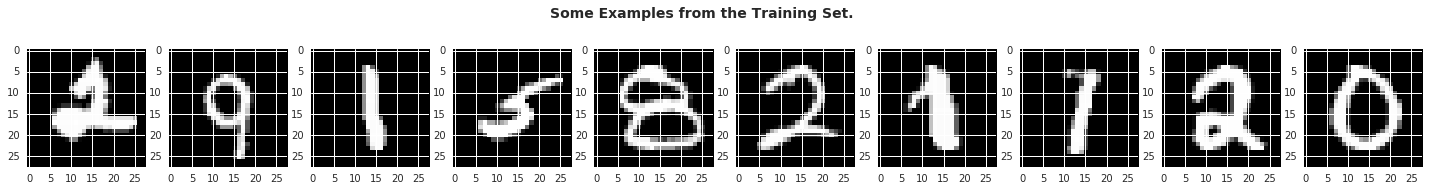

In [0]:
from matplotlib import pyplot as plt

plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Helper plotting routine.
def display_images(gens, title=""):
  fig, axs = plt.subplots(1, 10, figsize=(25, 3))
  fig.suptitle(title, fontsize=14, fontweight='bold')
  
  for i in xrange(10):
    reshaped_img = (gens[i].reshape(28, 28) * 255).astype(np.uint8)
    axs.flat[i].imshow(reshaped_img)
    #axs.flat[i].axis('off')    
  return fig, axs


batch_xs, batch_ys = mnist.train.next_batch(10)
list_of_images = np.split(batch_xs, 10)
_ = display_images(list_of_images, "Some Examples from the Training Set.")
plt.show()

# Building a Feed-Forward Neural Network

In this section, we will build a neural network that takes the raw MNIST pixels as inputs and outputs 10 values, which we will interpret as the probability that the input image belongs to one of the 10 digit classes (0 through 9). Along the way, the data will pass through the hidden layers and activation functions we encountered in the first practical. 

**NOTE**: Standard feedforward neural network architectures can be summarised by chaining together the number of neurons in each layer, e.g. "784-500-300-10" would be a net with 784 input neurons, followed by a layer with 500 neurons, then 300, and finally 10 output classes. 

## Build the model

We want to explore the different choices and some of the best practices of training feedforward neural networks on the MNIST dataset. In this practical we will only be using "fully connected" (also referred to as "FC", "affine", or "dense") layers (i.e. no convolutional layers). So let's first write a little helper function to construct these:

In [0]:
def _dense_linear_layer(inputs, layer_name, input_size, output_size):
  """
  Builds a layer that takes a batch of inputs of size `input_size` and returns 
  a batch of outputs of size `output_size`.
     
  Args:
    inputs: A `Tensor` of shape [batch_size, input_size].
    layer_name: A string representing the name of the layer.
    input_size: The size of the inputs
    output_size: The size of the outputs
    
  Returns:
    out, weights: tuple of layer outputs and weights.
    
  """
  # Name scopes allow us to logically group together related variables.
  # Setting reuse=False avoids accidental reuse of variables between different runs.
  with tf.variable_scope(layer_name, reuse=False):
    # Create the weights for the layer
    layer_weights = tf.get_variable("weights",
                                    shape=[input_size, output_size], 
                                    dtype=tf.float32, 
                                    initializer=tf.random_normal_initializer())
    # Create the biases for the layer
    layer_bias = tf.get_variable("biases", 
                                 shape=[output_size], 
                                 dtype=tf.float32, 
                                 initializer=tf.random_normal_initializer())
    
    outputs = tf.matmul(inputs, layer_weights) + layer_bias
  
  return (outputs, layer_weights)


Now let's use this to construct a linear softmax classifier as before, which we will expand into a near state-of-the-art feed-forward model for MNIST. We first create an abstract `BaseSoftmaxClassifier` base class that houses common functionality between the models. Each specific model will then provide a `build_model` method that represents the logic of that specific model.

In [0]:
class BaseSoftmaxClassifier(object):
  def __init__(self, input_size, output_size, l2_lambda):    
    # Define the input placeholders. The "None" dimension means that the 
    # placeholder can take any number of images as the batch size. 
    self.x = tf.placeholder(tf.float32, [None, input_size])
    self.y = tf.placeholder(tf.float32, [None, output_size])  
    self.input_size = input_size
    self.output_size = output_size
    self.l2_lambda = l2_lambda

    self._all_weights = [] # Used to compute L2 regularization in compute_loss().
    
    # You should override these in your build_model() function.
    self.logits = None
    self.predictions = None
    self.loss = None
    
    self.build_model()
    
  def get_logits(self):
    return self.logits
  
  def build_model(self):
    # OVERRIDE THIS FOR YOUR PARTICULAR MODEL.
    raise NotImplementedError("Subclasses should implement this function!")
    
  def compute_loss(self):
    """All models share the same softmax cross-entropy loss."""
    assert self.logits is not None  # Ensure that logits has been created! 
    data_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
    reg_loss = 0.
    for w in self._all_weights:
      reg_loss += tf.nn.l2_loss(w)
      
    return data_loss + self.l2_lambda * reg_loss
  
  def accuracy(self):
    # Calculate accuracy.
    assert self.predictions is not None  # Ensure that pred has been created!
    correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return accuracy

If we wanted to reimplement the linear softmax classifier from before, we just need to override `build_model()` to perform one projection from the input to the output logits, like this:

In [0]:
class LinearSoftmaxClassifier(BaseSoftmaxClassifier):
  def __init__(self, num_input, num_output, l2_lambda):
    super(LinearSoftmaxClassifier, self).__init__(input_size, 
                                                  output_size, 
                                                  l2_lambda)
    
  def build_model(self):
    # The model takes x as input and produces output_size outputs.
    self.logits, weights = _dense_linear_layer(
        self.x, "linear_layer", self.input_size, self.output_size)
    
    self._all_weights.append(weights)
    
    self.predictions = tf.nn.softmax(self.logits)
    self.loss = self.compute_loss()


In order to build a ***deeper*** model, let's add several layers with multiple transformations:

```python
def build_model(self):
   # The first layer takes x as input and has n_hidden_1 outputs.
   layer1, weights1 = _build_linear_layer(self.x, "layer1", self.num_input, self.num_hidden_1)
   self._all_weights.append(weights1)
   layer1 = self.act_fn(layer1)
    
   # The second layer takes layer1's output as its input and has num_hidden_2 outputs.
   layer2, weights2 = _build_linear_layer(layer1, "layer2", self.num_hidden_1, self.num_hidden_2)
   self._all_weights.append(weights2)
   layer2 = self.act_fn(layer2)
   
   # The final layer is our predictions and goes from num_hidden_2 inputs to 
   # num_classes outputs. The outputs are "logits", un-normalised scores. 
   self.logits, weights3 = _build_linear_layer(layer2, "output", n_hidden_2, n_classes)
   self._all_weights.append(weights3)
   
   self.pred = tf.nn.softmax(self.logits)
   self.loss = self.compute_loss(self.logits, self.y)
 ```

**Note: Instead of writing special classes for linear nets (0 hidden layers), 1 hidden layer nets, 2 hidden layer nets, etc., we can generalize this as follows:**

In [0]:
class DNNClassifier(BaseSoftmaxClassifier):
  """DNN = Deep Neural Network - now we're doing Deep Learning! :)"""
  
  def __init__(self, 
               input_size=784,  # There are 28x28 = 784 pixels in MNIST images
               hidden_sizes=[],  # List of hidden layer dimensions, empty for linear model.
               output_size=10,  # There are 10 possible digit classes
               act_fn=tf.nn.relu,  # The activation function to use in the hidden layers
               l2_lambda=0.):  # The strength of regularisation, off by default.
    
    self.hidden_sizes = hidden_sizes
    self.act_fn = act_fn
    super(DNNClassifier, self).__init__(input_size, output_size, l2_lambda)
    
    
  def build_model(self):
    prev_layer = self.x
    prev_size = self.input_size
    
    for layer_num, size in enumerate(self.hidden_sizes):    
      layer_name = "layer_" + str(layer_num)
      layer, weights = _dense_linear_layer(prev_layer, layer_name, prev_size, size)

      self._all_weights.append(weights)
      layer = self.act_fn(layer)
      prev_layer, prev_size = layer, size

    # The final layer is our predictions and goes from prev_size inputs to 
    # output_size outputs. The outputs are "logits", un-normalised scores. 
    self.logits, out_weights = _dense_linear_layer(prev_layer, "output", prev_size, self.output_size)
    self._all_weights.append(out_weights)
    
    self.predictions = tf.nn.softmax(self.logits)
    self.loss = self.compute_loss()
  

We can now create a linear model, i.e. 784-10 architecture (there is only one..), as follows:

```python
  tf_linear_model = DNNClassifier(input_size=784, hidden_sizes=[], output_size=10)
```

We can create a deep neural network (DNN, also called a "multi-layer perceptron") model, e.g. a 784-512-10 architecture (there can be many others...), as follows:

```python
  tf_784_512_10_model = DNNClassifier(input_size=784, hidden_sizes=[512], output_size=10)
```

and so forth.

**NOTE: Make sure you understand how this works before you move on.**

## Sanity Checks

### Dealing with randomness

Pseudo-random number generators start from some value (the 'seed') and generate numbers which appear to be random. It is good practise to seed RNGs with a fixed value to encourage reproducibility of results. We do this in NumPy by using `np.random.seed(1234)`, where `1234` is your chosen seed value. 

In TensorFlow we can set a *graph-level* seed (global, using `tf.set_random_seed(1234)`) or an *op-level* seed (passed in to each op via the `seed` argument, to override the graph-level seed.)

Next we need to initialize the parameters of our model. We do *not* want to initialize all weights to be the same. 

**QUESTION**: Can you think of why this might be a bad idea? (Think about a simple MLP with one input and 2 hidden units and one output. Look at the contributions via each weight connection to the activations on the hidden layer. Now let those weights be equal. How does that affect the contributions? How does that affect the update that backprop would propose for each weight? Do you see any problems?)

The simplest approach is to **initialize weights (W's) to small random values**. For ReLUs specifically, it is recommended to initialize weights to `np.random.randn(n) * sqrt(2.0/n)`, where `n` is the number of inputs to that layer (neuron on the previous layer).

Biases are not that sensitive to initialization and can be initialized to 0s or small random numbers.

### Check the loss of a random model

When we have a new model, it's always a good idea to do a quick sanity check. A random model that predicts C classes on random data should have no reason for preferring either class, i.e., on average its loss (negative log-likelihood) should be $-\log(1/C) = -\log(C^{-1}) = \log(C)$. 

**NOTE**: TF actually computes the cross-entropy on the *logits* for numerical stability reasons (logs of small numbers blow up quickly..). This means we'll get a different value from `tf.nn.softmax_cross_entropy_with_logits`. So for this check we will just manually compute the cross-entropy (negative log-likelihood).

The second thing to check is that adding the L2 loss (a strictly positive value), should *increase* total loss (here we'll just use the TF cross-entropy as provided).

In [0]:
tf.set_random_seed(1234)
np.random.seed(1234)

# Generate a batch of 100 "images" of 784 pixels consisting of Gaussian noise.
x_rnd = np.random.randn(100, 784)
print "Sample of random data:\n", x_rnd[:5,:]  # Print the first 5 "images"
print "Shape: ", x_rnd.shape
# Generate some random one-hot labels.
y_rnd = np.eye(10)[np.random.choice(10, 100)]
print "Sample of random labels:\n", y_rnd[:5,:]
print "Shape: ", y_rnd.shape

# Model without regularization.
tf.reset_default_graph()
tf_linear_model = DNNClassifier(l2_lambda=0.0)
x, y = tf_linear_model.x, tf_linear_model.y

with tf.Session() as sess:
  # Initialize variables.
  init = tf.global_variables_initializer()
  sess.run(init)
  
  avg_cross_entropy = -tf.log(tf.reduce_mean(tf_linear_model.predictions))
  loss_no_reg = tf_linear_model.loss
 
  manual_avg_xent, loss_no_reg = sess.run([avg_cross_entropy, loss_no_reg],
                                          feed_dict={x : x_rnd, y: y_rnd})
  
  
# Sanity check: Loss should be about log(10) = 2.3026
print '\nSanity check manual avg cross entropy: ', manual_avg_xent
print 'Model loss (no reg): ', loss_no_reg

# Model with regularization.
tf.reset_default_graph()
tf_linear_model = DNNClassifier(l2_lambda=1.0)
x, y = tf_linear_model.x, tf_linear_model.y

with tf.Session() as sess:
  # Initialize variables.
  init = tf.global_variables_initializer()
  sess.run(init)
  loss_w_reg = tf_linear_model.loss.eval(feed_dict={x : x_rnd, y: y_rnd})

# Sanity check: Loss should go up when you add regularization
print 'Sanity check loss (with regularization, should be higher): ', loss_w_reg

Sample of random data:
[[ 0.47143516 -1.19097569  1.43270697 ..., -0.2453605  -1.26943186
  -0.26232386]
 [ 2.33759848 -0.78171744  0.08009975 ..., -0.64055353  1.76256841
  -0.08567302]
 [ 1.63617833 -0.54410827 -1.04999868 ..., -0.90640906  0.31915076
  -0.49914386]
 [-0.66039926  0.0774697   0.38755182 ...,  0.31019053  1.87791254
  -0.70183467]
 [-3.23350453  0.20024296 -0.13933709 ..., -0.72622006  0.50774695
   0.18987136]]
Shape:  (100, 784)
Sample of random labels:
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
Shape:  (100, 10)

Sanity check manual avg cross entropy:  2.30259
Model loss (no reg):  45.2449
Sanity check loss (with regularization, should be higher):  3981.99


### Compute & Verify the Gradients

***TODO(sgouws)***: Discuss numerical gradient checking.

* Discuss how to do in TF. (https://www.tensorflow.org/versions/r0.12/api_docs/python/test/gradient_checking). 
* Discuss best practice.

## Training deep neural networks

Now that we have a model with a loss and gradients, let's write a function to train it! This will be largely similar to the `train_tf_model()` function (same name, see below) from the previous practical. However, we are introducing several new concepts in this practical:

* how to update parameters: different optimizers, 
* model complexity and how to match this to your data: 
  * recognizing overfitting 
  * adding regularization (L2, dropout)
* knowing when to stop training: early stopping,

As we go through these concepts, we will show how to use them in our training function.

### Optimizers

Training neural networks involves solving an optimization problem. **Stochastic gradient-based methods** are by far the most popular family of techniques that are being used for this. These methods evaluate the gradient of the loss on a small part of the data (called a **minibatch**), and then propose a small change to the weights based on the current sample (and some maintain running averages over the previous steps), that reduces the loss, before moving on to another sample of the data:

```
step = optimimizer(grad(cost), learning_rate, ...) 
new_weights = old_weights + step
```

The oldest algorithm is stochastic gradient descent, but there are many others (Adagrad, AdaDelta, RMSProp, ADAM, etc.). See this great note for an overview: https://arxiv.org/abs/1609.04747. As a general rule of thumb, ADAM or SGD with Momentum tend to work quite well out of the box, but this depends on your model and your data! 

We can select different optimization functions by passing in a different optimizer to `train_tf_model` (see the full list here: https://www.tensorflow.org/api_guides/python/train#Optimizers) as follows:

```python

optimizer = tf.train.RMSProp(...)
results_tuple = train_tf_model(optimizer_fn=optimizer, ...)
```

### Model complexity, overfitting & regularization

**Overfitting** occurs when improving the model's training loss (its performance on training data) comes at the expense of its **generalisation ability** (its performance on unseen test data). Generally it is a symptom of the **model complexity** increasing to fit the training data very accurately. You can think of complexity as how "wiggly" or "wrinkly" the decision boundary that the model can represent is. We can increase model complexity by adding more layers. We can control or reduce the model complexity of an architecture using a family of techniques called **regularisation**. 

<img src="figs/over_and_under_fitting.png" width="500">

We've already encountered L2-regularisation (also called **weight-decay**), where we penalise the model for having very large weights. A very popular current technique is called **dropout** (we'll look at this in more detail in Practical 3). There are many others, but these two are the most popular.

We will only be using L2 regularization in this practical. It can be set by passing a non-zero value to `l2_lambda` when constructing a `DNNClassifier` instance.

### Early stopping

Neural networks are nonlinear models and can have very complicated optimization landscapes. Stochastic gradient based methods for optimizing these loss functions do not proceed monotonically (i.e. does not just keep going up). Sometimes the loss can go down for a while before it goes up to reach a better part of parameter space later. How do we know when to stop training?

**Early stopping** is one technique that helps with this. It is added to the training routine and means that we periodically evaluate the model's performance on the validation set (***Crucially! not the test set. Why?***). If the performance on the validation set starts becoming worse we know we have reached the point of overfitting (usually), so it usually makes sense to stop training and not waste any more computations. 

<img src="figs/early_stopping.png">

The `train_tf_model` function we built earlier has an early-stopping feature that you can enable by passing the `stop_early=True` parameter. Have a look at the code to see how this is done. 

For this practical, we just implemented the most basic idea of early stopping: stop training as soon as the model starts doing worse on validation data. However, there are different ways of implementing this idea. Two of the most popular are 

* "early stopping with patience": don't stop training immediately once validation accuracy degrades, but wait for P more epochs, and reset P if the model starts improving again within this timeframe,
* training for T epochs, and simply selecting the best model based on validation score over the entire T epochs.

**QUESTION**: What are the pros and cons of these different methods?

## Wrapping these ideas into the training function

The training function below implements all the ideas we discussed above.

In [0]:
class MNISTFraction(object):
  """A helper class to extract only a fixed fraction of MNIST data."""
  def __init__(self, mnist, fraction):
    self.mnist = mnist
    self.num_images = int(mnist.num_examples * fraction)
    self.image_data, self.label_data = mnist.images[:self.num_images], mnist.labels[:self.num_images]
    self.start = 0
    
  def next_batch(self, batch_size):
    start = self.start
    end = min(start + batch_size, self.num_images)
    self.start = 0 if end == self.num_images else end
    return self.image_data[start:end], self.label_data[start:end]

In [0]:
def train_tf_model(tf_model,                   
                   session,  # The active session.
                   num_epochs,  # Max epochs/iterations to train for.
                   batch_size=50,  # Number of examples per batch.
                   keep_prob=1.0,  # (1. - dropout) probability, none by default.
                   train_only_on_fraction=1.,  # Fraction of training data to use.
                   optimizer_fn=None,  # TODO(sgouws): more correct to call this optimizer_obj
                   report_every=1, # Report training results every nr of epochs.
                   eval_every=1,  # Evaluate on validation data every nr of epochs.
                   stop_early=True,  # Use early stopping or not.
                   verbose=True): 

  # Get the (symbolic) model input, output, loss and accuracy.
  x, y = tf_model.x, tf_model.y
  loss = tf_model.loss
  accuracy = tf_model.accuracy()

  # Compute the gradient of the loss with respect to the model parameters 
  # and create an op that will perform one parameter update using the specific
  # optimizer's update rule in the direction of the gradients.
  if optimizer_fn is None:
    optimizer_fn = tf.train.AdamOptimizer()
  optimizer_step = optimizer_fn.minimize(loss)

  # Get the op which, when executed, will initialize the variables.
  init = tf.global_variables_initializer()
  # Actually initialize the variables (run the op).
  session.run(init)

  # Save the training loss and accuracies on training and validation data.
  train_costs = []
  train_accs = []
  val_costs = []
  val_accs = []

  if train_only_on_fraction < 1:
    mnist_train_data = MNISTFraction(mnist.train, train_only_on_fraction)
  else:
    mnist_train_data = mnist.train
  
  prev_c_eval = 1000000
  
  # Main training cycle.
  for epoch in range(num_epochs):

    avg_cost = 0.
    avg_acc = 0.
    total_batch = int(train_only_on_fraction * mnist.train.num_examples / batch_size)

    # Loop over all batches.
    for i in range(total_batch):
      batch_x, batch_y = mnist_train_data.next_batch(batch_size)
            
      # Run optimization op (backprop) and cost op (to get loss value),
      # and compute the accuracy of the model.
      feed_dict = {x: batch_x, y: batch_y}
      if keep_prob < 1.:
        feed_dict["keep_prob:0"] = keep_prob
        
      _, c, a = session.run(
          [optimizer_step, loss, accuracy], feed_dict=feed_dict)
            
      # Compute average loss/accuracy
      avg_cost += c / total_batch
      avg_acc += a / total_batch      
    
    train_costs.append((epoch, avg_cost))
    train_accs.append((epoch, avg_acc))

    # Display logs per epoch step
    if epoch % report_every == 0 and verbose:
      print "Epoch:", '%04d' % (epoch+1), "Training cost=", \
            "{:.9f}".format(avg_cost)
        
    if epoch % eval_every == 0:
      val_x, val_y = mnist.validation.images, mnist.validation.labels      
      
      feed_dict = {x : val_x, y : val_y}
      if keep_prob < 1.:
        feed_dict['keep_prob:0'] = 1.0
        
      c_eval, a_eval = session.run([loss, accuracy], feed_dict=feed_dict)
      
      if verbose:
        print "Epoch:", '%04d' % (epoch+1), "Validation acc=", \
              "{:.9f}".format(a_eval)
        
      if c_eval >= prev_c_eval and stop_early:
        print "Validation loss stopped improving, stopping training early after %d epochs!" % (epoch + 1)
        break
        
      prev_c_eval = c_eval
        
      val_costs.append((epoch, c_eval))
      val_accs.append((epoch, a_eval))
      
  
  print "Optimization Finished!"
  return train_costs, train_accs, val_costs, val_accs

  

In [0]:
# Helper functions to plot training progress.

def my_plot(list_of_tuples):
  """Take a list of (epoch, value) and split these into lists of 
  epoch-only and value-only. Pass these to plot to make sure we
  line up the values at the correct time-steps.
  """
  plt.plot(*zip(*list_of_tuples))

def plot_multi(values_lst, labels_lst, y_label, x_label='epoch'):
  # Plot multiple curves.
  assert len(values_lst) == len(labels_lst)
  plt.subplot(2, 1, 2)
  
  for v in values_lst:
    my_plot(v)
  plt.legend(labels_lst, loc='upper left')
  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()  


## Wrapping everything together and verifying that it works

Once we have a training function, it is usually a good idea to train on a small amount of your data first to verify that everything is indeed working. We can put all the pieces together to achieve this as follows:

In [0]:
##### BUILD MODEL #####
tf.reset_default_graph()  # Clear the graph.
model = DNNClassifier()   # Choose model hyperparameters.

with tf.Session() as sess:

  ##### TRAIN MODEL #####

  train_losses, train_accs, val_losses, val_accs = train_tf_model(
      model,
      session=sess,
      num_epochs=10, 
      train_only_on_fraction=1e-1,
      optimizer_fn=tf.train.GradientDescentOptimizer(learning_rate=1e-3),
      report_every=1,
      eval_every=2,
      stop_early=False) 

  ##### EVALUATE MODEL ON TEST DATA #####

  # Get the op which calculates model accuracy.
  accuracy_op = model.accuracy()  # Get the symbolic accuracy operation
  
  # Connect the MNIST test images and labels to the model input/output
  # placeholders, and compute the accuracy given the trained parameters.
  accuracy = accuracy_op.eval(feed_dict = {model.x: mnist.test.images, 
                                           model.y: mnist.test.labels})

Epoch: 0001 Training cost= 14.689428676
Epoch: 0001 Validation acc= 0.082599998
Epoch: 0002 Training cost= 14.121777500
Epoch: 0003 Training cost= 13.628664155
Epoch: 0003 Validation acc= 0.084599994
Epoch: 0004 Training cost= 13.195314789
Epoch: 0005 Training cost= 12.809673691
Epoch: 0005 Validation acc= 0.086799994
Epoch: 0006 Training cost= 12.462840531
Epoch: 0007 Training cost= 12.148492813
Epoch: 0007 Validation acc= 0.088799991
Epoch: 0008 Training cost= 11.861907248
Epoch: 0009 Training cost= 11.599315002
Epoch: 0009 Validation acc= 0.093199998
Epoch: 0010 Training cost= 11.357611448
Optimization Finished!


In the rest of this practical, we will explore the effects of different model hyperparameters and different training choices, so let's wrap everything together to emphasize these different choices, and then train a simple model for a few epochs to verify that everything works.

Instead of just training and checking that the loss goes down, it is usually a good idea to try to **overfit a small subset of your training data**. We will do this below by training a single layer network on a subset of the MNIST training data, by setting the `train_only_on_fraction` training hyperparameter to 0.05 (i.e. 5%). We turn off early stopping for this.

**QUESTION**: Why do we turn off early-stopping?

Epoch: 0001 Training cost= 139.290022673
Epoch: 0001 Validation acc= 0.280399978
Epoch: 0002 Training cost= 66.074478573
Epoch: 0003 Training cost= 39.402559280
Epoch: 0003 Validation acc= 0.600199938
Epoch: 0004 Training cost= 27.986713763
Epoch: 0005 Training cost= 21.399133824
Epoch: 0005 Validation acc= 0.692799866
Epoch: 0006 Training cost= 17.036395073
Epoch: 0007 Training cost= 13.914142732
Epoch: 0007 Validation acc= 0.737599850
Epoch: 0008 Training cost= 11.619504205
Epoch: 0009 Training cost= 9.711225218
Epoch: 0009 Validation acc= 0.763999879
Epoch: 0010 Training cost= 8.104175338
Epoch: 0011 Training cost= 6.946027897
Epoch: 0011 Validation acc= 0.779799759
Epoch: 0012 Training cost= 6.293548434
Epoch: 0013 Training cost= 5.277549549
Epoch: 0013 Validation acc= 0.789399862
Epoch: 0014 Training cost= 4.761320768
Epoch: 0015 Training cost= 4.130910303
Epoch: 0015 Validation acc= 0.796799839
Epoch: 0016 Training cost= 3.657322904
Epoch: 0017 Training cost= 2.984719227
Epoch: 0

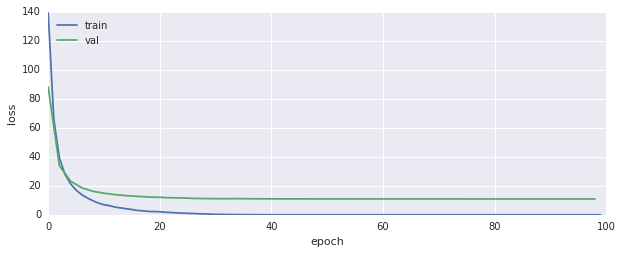

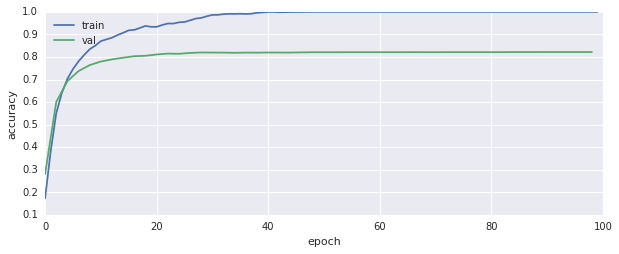

In [0]:
# NOTE THE CODE TEMPLATE BELOW WRAPS ALL OF THE ABOVE CODE, AND EXPOSES ONLY THE 
# DIFFERENT HYPERPARAMETER CHOICES. MAKE SURE YOU UNDERSTAND EXACTLY HOW
# THE ABOVE CODE WORKS FIRST. TO SAVE SOME SPACE, WE WILL COPY AND MODIFY THE 
# CODE BELOW TO BUILD AND TRAIN DIFFERENT MODELS IN THE REST OF THIS PRACTICAL. 
# YOU CAN USE WHICHEVER VERSION YOU PREFER FOR YOUR OWN EXPERIMENTS.

# Helper to wrap building, training, evaluating and plotting model accuracy.

def build_train_eval_and_plot(build_params, train_params, verbose=True):
  tf.reset_default_graph()
  m = DNNClassifier(**build_params)

  with tf.Session() as sess:
    # Train model on the MNIST dataset.
   
    train_losses, train_accs, val_losses, val_accs = train_tf_model(
        m, 
        sess,
        verbose=verbose,
        **train_params) 
    
    # Now evaluate it on the test set:
  
    accuracy_op = m.accuracy()  # Get the symbolic accuracy operation
    # Calculate the accuracy using the test images and labels.
    accuracy = accuracy_op.eval({m.x: mnist.test.images, 
                                 m.y: mnist.test.labels})  
    
    if verbose: 
      print "Accuracy on test set:", accuracy
      # Plot losses and accuracies.
      plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
      plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
      
    
    ret = {'train_losses': train_losses, 'train_accs' : train_accs,
           'val_losses' : val_losses, 'val_accs' : val_accs,
           'test_acc' : accuracy}
    
    return m, ret

#################################CODE TEMPLATE##################################
# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
    #'input_size' : 784,  # There are 28x28 = 784 pixels in MNIST images
    'hidden_sizes' : [512], # List of hidden layer dimensions, empty for linear model.
    #'output_size' : 10,  # There are 10 possible digit classes
    #'act_fn' : tf.nn.relu,  # The activation function to use in the hidden layers
    'l2_lambda' : 0.      # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 100,   # Max epochs/iterations to train for.
            #'batch_size' : 100,  # Number of examples per batch, 100 default.
            #'keep_prob' : 1.0,  # (1. - dropout) probability, none by default.
            'train_only_on_fraction' : 5e-2,  # Fraction of training data to use, 1. for everything.
            'optimizer_fn' : None,  # Optimizer, None for Adam.
            'report_every' : 1, # Report training results every nr of epochs.
            'eval_every' : 2,   # Evaluate on validation data every nr of epochs.
            'stop_early' : False,  # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True  # Modify as desired.
)

###############################END CODE TEMPLATE################################

Above we plot the training loss vs the validation loss and the training accuracy vs the validation accuracy on only 5% (`train_only_on_fraction=5e-3`) of the training data (so that it doesn't take too long, and also so that our model can overfit easier). We see that the loss is coming down and the accuracies are going up, as expected! By training on a small subset of the training data, we established that 

* the data that the model is being trained on is hopefully not corrupt (this can happen during preprocessing, loading, etc), 
* our loss and gradients are likely correct, 
* our optimizer seems to do the right thing, 
* and generally, that our code probably works! 

**NOTE**: Notice the point where training loss/accuracy continues to improve, but validation accuracy starts to plateau? That is the point where the model starts to **overfit** the training data.


# Architectural Choices

## Depth

### A Linear 784-10 Model

Let's evaluate the simple linear model trained on the full dataset and then add layers to see what effect this will have on the accuracy.

**NOTE**: If you're unsure what the "784-10" notation means, scroll up and re-read the section on "Building a Feed-forward Neural Network" where we explain that.

Epoch: 0001 Training cost= 6.289445279
Epoch: 0001 Validation acc= 0.571999967
Epoch: 0002 Training cost= 1.742072467
Epoch: 0002 Validation acc= 0.751799881
Epoch: 0003 Training cost= 1.125335374
Epoch: 0003 Validation acc= 0.808199823
Epoch: 0004 Training cost= 0.885549906
Epoch: 0004 Validation acc= 0.835999787
Epoch: 0005 Training cost= 0.752449530
Epoch: 0005 Validation acc= 0.850599706
Epoch: 0006 Training cost= 0.665232495
Epoch: 0006 Validation acc= 0.861999750
Epoch: 0007 Training cost= 0.608093028
Epoch: 0007 Validation acc= 0.872599781
Epoch: 0008 Training cost= 0.558296646
Epoch: 0008 Validation acc= 0.874999762
Epoch: 0009 Training cost= 0.520905022
Epoch: 0009 Validation acc= 0.880999744
Epoch: 0010 Training cost= 0.493353598
Epoch: 0010 Validation acc= 0.886199713
Epoch: 0011 Training cost= 0.466140029
Epoch: 0011 Validation acc= 0.889799714
Epoch: 0012 Training cost= 0.450120537
Epoch: 0012 Validation acc= 0.892999768
Epoch: 0013 Training cost= 0.433938463
Epoch: 0013 V

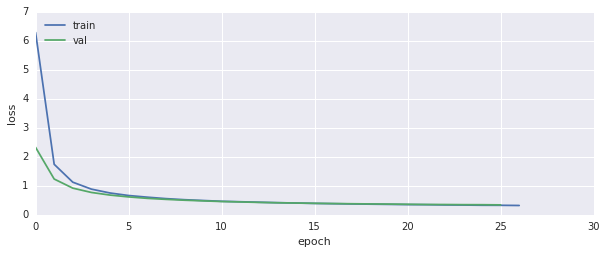

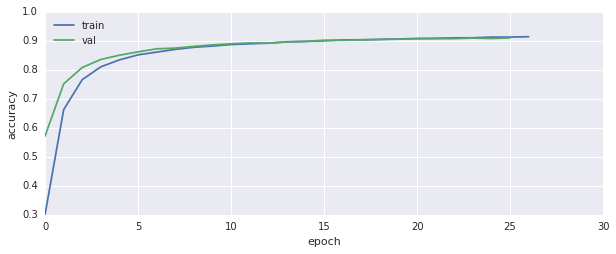

CPU times: user 35.5 s, sys: 4.12 s, total: 39.6 s
Wall time: 24 s


In [0]:
%%time
# Train the linear model on the full dataset.

"""
tf.reset_default_graph()
tf_linear_model = DNNClassifier(l2_lambda=0.)
x, y = tf_linear_model.x, tf_linear_model.y

with tf.Session() as sess:
   
  train_losses, train_accs, val_losses, val_accs = train_tf_model(
      tf_linear_model,
      session=sess,
      num_epochs=50, 
      report_every=1,
      eval_every=1,
      stop_early=True) 
  
  # Now evaluate it on the test set:
  
  accuracy_op = tf_linear_model.accuracy()  # Get the symbolic accuracy operation
  accuracy = accuracy_op.eval({x: mnist.test.images, y: mnist.test.labels})  # Calcuate the accuracy using the test images and labels
  print "Accuracy on test set:", accuracy
  
  # Plot curves.
  plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
  plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
"""

################################################################################
# Specify the model hyperparameters.
model_params = {'l2_lambda' : 0.}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 50,   # Max epochs/iterations to train for.
            'optimizer_fn' : None,      # Now we're using Adam.
            'report_every' : 1, # Report training results every nr of epochs.
            'eval_every' : 1,   # Evaluate on validation data every nr of epochs.
            'stop_early' : True  
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True  # Modify as desired.
)

################################################################################

~91% is quite a bad score on MNIST! Now let's build a deeper model, to improve on that score. 

### 1 hidden layer: 784-512-10 Architecture w/ L2

Notice that we add a bit of L2-regularization to our model.

**QUESTION**: What does that do? What is the effect of removing it? Try it!

Epoch: 0001 Training cost= 199.931141524
Epoch: 0001 Validation acc= 0.870599747
Epoch: 0002 Training cost= 141.988723103
Epoch: 0002 Validation acc= 0.898999751
Epoch: 0003 Training cost= 113.183370292
Epoch: 0003 Validation acc= 0.912399769
Epoch: 0004 Training cost= 93.298404125
Epoch: 0004 Validation acc= 0.922599733
Epoch: 0005 Training cost= 78.503151592
Epoch: 0005 Validation acc= 0.921799719
Epoch: 0006 Training cost= 66.877790590
Epoch: 0006 Validation acc= 0.935599744
Epoch: 0007 Training cost= 57.344941926
Epoch: 0007 Validation acc= 0.935999691
Epoch: 0008 Training cost= 49.325550454
Epoch: 0008 Validation acc= 0.943399668
Epoch: 0009 Training cost= 42.386559400
Epoch: 0009 Validation acc= 0.940399766
Epoch: 0010 Training cost= 36.450480402
Epoch: 0010 Validation acc= 0.946999669
Epoch: 0011 Training cost= 31.281487076
Epoch: 0011 Validation acc= 0.944399714
Epoch: 0012 Training cost= 26.775760117
Epoch: 0012 Validation acc= 0.944599748
Epoch: 0013 Training cost= 22.8883921

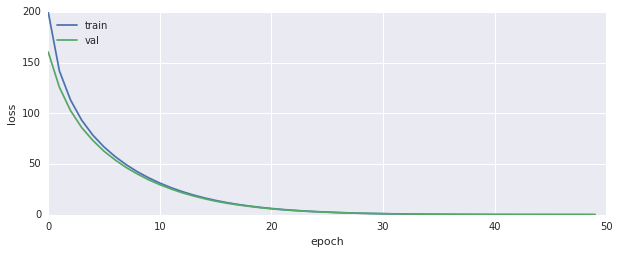

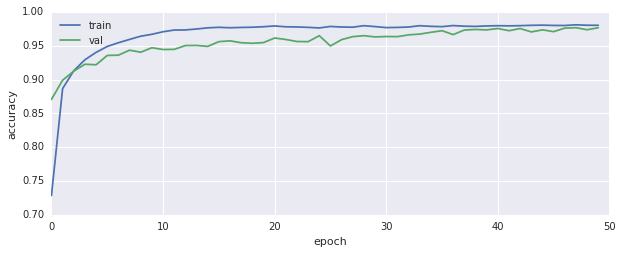

CPU times: user 1min 27s, sys: 12.2 s, total: 1min 39s
Wall time: 1min 4s


In [0]:
%%time

"""
tf.reset_default_graph()
tf_512_model = DNNClassifier(hidden_sizes=[512], l2_lambda=1e-3)
x, y = tf_512_model.x, tf_512_model.y

with tf.Session() as sess:
  # Train the linear model on the MNIST dataset
  train_losses, train_accs, val_losses, val_accs = train_tf_model(
      tf_512_model,
      session=sess,
      num_epochs=50, # early stopping stops around 47, so we're good
      report_every=1,
      eval_every=1,
      stop_early=True)
  
  # Now evaluate it on the test set:
  accuracy = tf_512_model.accuracy()
  print "Accuracy on test set:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels})
  
  # Plot curves.
  plot_train_val_losses_and_accs(train_losses, val_losses, train_accs, val_accs)
"""
  
# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
    'hidden_sizes' : [512],  # List of hidden layer dimensions, empty for linear model.
    'l2_lambda' : 1e-3      # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {
    'num_epochs' : 50,    # Max epochs/iterations to train for.
    'report_every' : 1,   # Report training results every nr of epochs.
    'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
    'stop_early' : True  # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True  # Modify as desired.
)

**97.7%** is a much more decent score! The 1 hidden layer model gives a much better score than the linear model, so let's see if we can do better by adding another layer!

### Going deeper! A 784-512-512-10 architecture w/ L2

Epoch: 0001 Training cost= 576.249123591
Epoch: 0001 Validation acc= 0.901599765
Epoch: 0002 Training cost= 356.557729048
Epoch: 0002 Validation acc= 0.921399713
Epoch: 0003 Training cost= 317.592652199
Epoch: 0003 Validation acc= 0.931799769
Epoch: 0004 Training cost= 293.989943626
Epoch: 0004 Validation acc= 0.937399745
Epoch: 0005 Training cost= 276.594365179
Epoch: 0005 Validation acc= 0.944599748
Epoch: 0006 Training cost= 263.482251143
Epoch: 0006 Validation acc= 0.946799755
Epoch: 0007 Training cost= 251.240891252
Epoch: 0007 Validation acc= 0.945599735
Epoch: 0008 Training cost= 241.220871305
Epoch: 0008 Validation acc= 0.949199736
Epoch: 0009 Training cost= 231.527150657
Epoch: 0009 Validation acc= 0.950399697
Epoch: 0010 Training cost= 222.198544922
Epoch: 0010 Validation acc= 0.953399718
Epoch: 0011 Training cost= 213.551616044
Epoch: 0011 Validation acc= 0.955799699
Epoch: 0012 Training cost= 204.914471547
Epoch: 0012 Validation acc= 0.957999706
Epoch: 0013 Training cost= 1

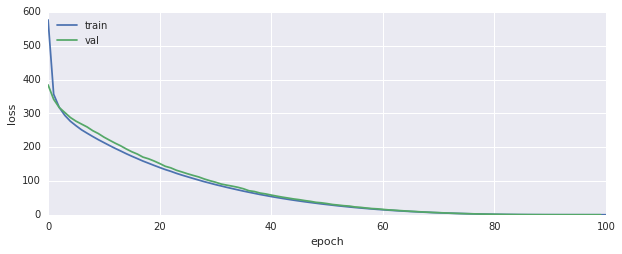

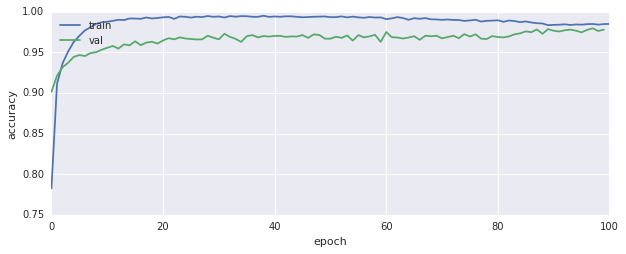

CPU times: user 3min 43s, sys: 22 s, total: 4min 5s
Wall time: 2min 46s


In [0]:
%%time 

"""
tf.reset_default_graph()
tf_512_512_10_model = DNNClassifier(hidden_sizes=[512, 512], l2_lambda=1e-3)
x, y = tf_512_512_10_model.x, tf_512_512_10_model.y

with tf.Session() as sess:
  train_losses, train_accs, val_losses, val_accs = train_tf_model(
      tf_512_512_10_model,
      session=sess,
      num_epochs=200, 
      report_every=1,
      eval_every=1,
      stop_early=True)
  
  # Now evaluate it on the test set:
  accuracy = tf_512_512_10_model.accuracy()
  print "Accuracy on test set:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels})
  
  # Plot curves.
  plot_train_val_losses_and_accs(train_losses, val_losses, train_accs, val_accs) 
"""
  
# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
    'hidden_sizes' : [512, 512], # List of hidden layer dimensions, empty for linear model.
    'l2_lambda' : 1e-3           # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {
    'num_epochs' : 200,   # Max epochs/iterations to train for.
    'report_every' : 1,   # Report training results every nr of epochs.
    'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
    'stop_early' : True,  # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True  # Modify as desired.
)

  

**97.4**%? Shouldn't deeper do better?! Why is it that the 2-hidden layer model

* ***took much longer to train*** (2min 46s versus 1min 3s on our system), and
* ***got roughly the same accuracy*** as the 1 hidden layer model (sometimes worse)?

This illustrates the **fundamental difficulty of training deep networks** that have plagued deep learning research for decades (and to some extent, still do): 

> ***Although deeper networks can give you more powerful models, training those models to find the right parameters is not always easy & takes a lot of computing power (time)!***

For a long time people just believed it wouldn't work because a) fewer people tried to make it work, and those who did b) didn't have enough data or computing power to really explore the vast space of hyperparameters. These days, we have more data and more compute power, however one can never have 'enough' resources :) This is where the art of doing proper hyper-parameter selection comes in. In fact, we should be able to squeeze out another percentage point or so by choosing better:

* Optimizer + its hyperparams (learning rate, momentum rates, etc)
* batch-size,
* choice of regularization.

For a new problem, we will typically spend most of our time exploring these choices, usually just by launching many different training runs (hopefully in parallel and using GPUs!) and keeping the best ones.


# Extra: Hyperparameter Selection

## Random grid-search

Most of the deep learning practitioner's time will be spent training and evaluating new model architectures with different hyperparameter combinations.  General rules of thumb exist, but often times change for each new architecture or dataset. In practice, most people just use a randomized grid-search approach to try out different hyperparams, where one defines sensible values for each hyperparameter, and then randomly samples from the (cross-product space) of all of these possible combinations. This space grows exponentially, making exhaustive search infeasible for all but the simplest models. In practice, randomized search have also been found to find the best values, quicker (see [Bergstra and Bengio 2009](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) if you're interested in the details).

Below, we will illustrate the basic idea with a skeleton randomized grid search implementation. In practice, one would launch these different runs in parallel on a computing cluster, making it easier to explore multiple options at the same time. Here, we would just try out a few different options to get a sense for how that would work. 

**NOTE**: We will keep the models small here (so we won't get SOTA results), in order to keep the training times reasonable, but to illustrate how dependent results are on these choices.

**Architecture Selection**: Let's consider 1 and 2-hidden layer models. For each layer, we'll try out [128, 256] neurons per layer. We'll stick to ReLUs for this.

**Hyperparameters**: Let's pick SGD with Momentum as our optimizer (a good, stable workhorse), with a fixed computational budget of 20 training epochs. We'll need to pick ranges for the following:
* *learning rate*: we'll use a log-scale from 1e-5 to 1.
* *momentum coefficient*: we'll use a log-scale from 5e-1 (0.5) to 1.
* *L2 regularization*: we'll use a log-scale from 1e-5 to 1.


In [0]:
def sample_log_scale(v_min=1e-6, v_max=1.):
  '''Sample uniformly on a log-scale from 10**v_min to 10**v_max.'''
  return np.exp(np.random.uniform(np.log(v_min), np.log(v_max)))


def sample_model_architecture_and_hyperparams(max_num_layers=2,
                                              lr_min=1e-6,
                                              lr_max=1.,
                                              mom_min=0.5,
                                              mom_max=1.,
                                              l2_min=1e-4,
                                              l2_max=1.):
    '''Generate a random model architecture & hyperparameters.'''
    
    # Sample the architecture.
    num_layers = np.random.choice(range(1, max_num_layers+1))
    hidden_sizes = []
    layer_ranges=[128, 256]
    for l in range(num_layers):
      hidden_sizes.append(np.random.choice(layer_ranges))
    
    # Sample the training parameters.
    l2_lambda = sample_log_scale(l2_min, l2_max)
    lr = sample_log_scale(lr_min, lr_max)
    mom_coeff = sample_log_scale(mom_min, mom_max)
    
    # Build base model definitions:
    model_params = {
        'hidden_sizes' : hidden_sizes,
        'l2_lambda' : l2_lambda}

    # Specify the training hyperparameters:
    training_params = {
        'num_epochs' : 20,
        'optimizer_fn' : tf.train.MomentumOptimizer(
            learning_rate=lr, 
            momentum=mom_coeff),
        'report_every' : 1,
        'eval_every' : 1,
        'stop_early' : True}
    
    return model_params, training_params

# TEST THIS: Run this cell a few times and convince yourself things look sensible.
m, t = sample_model_architecture_and_hyperparams()
print m
print t


{'hidden_sizes': [256, 128], 'l2_lambda': 0.0054235896697678509}
{'eval_every': 1, 'report_every': 1, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x55725cae8a90>, 'num_epochs': 20, 'stop_early': True}


We will play around with the strength of the L2 regularization. Let's use SGD+Momentum, and run for a fixed budget of 20 epochs:

In [0]:
results = []

# Perform a random search over hyper-parameter space this many times.
NUM_EXPERIMENTS = 10

for i in range(NUM_EXPERIMENTS): 
  
  # Sample the model and hyperparams we are using.
  model_params, training_params = sample_model_architecture_and_hyperparams()
  
  print "RUN: %d out of %d:" % (i, NUM_EXPERIMENTS)
  print "Sampled Architecture: \n", model_params
  print "Hyper-parameters:\n", training_params
  
  # Build, train, evaluate
  model, performance = build_train_eval_and_plot(
      model_params, training_params, verbose=False)
  
  # Save results
  results.append((performance['test_acc'], model_params, training_params))
  
# Display (best?) results/variance/etc:
results.sort(key=lambda x : x[0], reverse=True)

RUN: 0 out of 10:
Sampled Architecture: 
{'hidden_sizes': [256], 'l2_lambda': 0.017639122106750327}
Hyper-parameters:
{'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x556eca7c8c90>}
Validation loss stopped improving, stopping training early after 3 epochs!
Optimization Finished!
RUN: 1 out of 10:
Sampled Architecture: 
{'hidden_sizes': [256], 'l2_lambda': 0.00071915651503389648}
Hyper-parameters:
{'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x556eca247f10>}
Optimization Finished!
RUN: 2 out of 10:
Sampled Architecture: 
{'hidden_sizes': [256], 'l2_lambda': 0.034917746813186976}
Hyper-parameters:
{'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.trainin

In [0]:
for r in results:
  print r  # Tuples of (test_accuracy, model_hyperparameters, training_hyperparameters)

(0.95090008, {'hidden_sizes': [128, 128], 'l2_lambda': 0.0066110195159220803}, {'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x556e59bd68d0>})
(0.94180018, {'hidden_sizes': [256], 'l2_lambda': 0.00064575036694946794}, {'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x556ecabea5d0>})
(0.92350012, {'hidden_sizes': [128, 128], 'l2_lambda': 0.013143246333050255}, {'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.tensorflow.python.training.momentum.MomentumOptimizer object at 0x556eb9135650>})
(0.8925001, {'hidden_sizes': [256], 'l2_lambda': 0.034917746813186976}, {'stop_early': True, 'report_every': 1, 'eval_every': 1, 'num_epochs': 20, 'optimizer_fn': <google3.third_party.te

**Notice the huuuuge variance in the test accuracies!** This is just a toy run, but hopefully it illustrates how important choosing the right architectures and training hyperparameters is to getting good results in deep learning.

Below, we've included some hyperparameter settings which achieve near state-of-the-art results.

# Known Good Models

## 784-500-300-10 w/ L2 + SGD + Momentum

**Best so far: 98.02% test accuracy when we ran this (well, in one of our training runs :).**

Epoch: 0001 Training cost= 327.262532238
Epoch: 0001 Validation acc= 0.435399979
Epoch: 0002 Training cost= 251.312214827
Epoch: 0002 Validation acc= 0.542799890
Epoch: 0003 Training cost= 224.936292614
Epoch: 0003 Validation acc= 0.605999947
Epoch: 0004 Training cost= 201.409107805
Epoch: 0004 Validation acc= 0.626999915
Epoch: 0005 Training cost= 180.312732350
Epoch: 0005 Validation acc= 0.656599879
Epoch: 0006 Training cost= 161.427582259
Epoch: 0006 Validation acc= 0.692799866
Epoch: 0007 Training cost= 144.570377253
Epoch: 0007 Validation acc= 0.730599880
Epoch: 0008 Training cost= 129.454500316
Epoch: 0008 Validation acc= 0.729999840
Epoch: 0009 Training cost= 115.930559138
Epoch: 0009 Validation acc= 0.764599860
Epoch: 0010 Training cost= 103.779861076
Epoch: 0010 Validation acc= 0.817999840
Epoch: 0011 Training cost= 92.894099121
Epoch: 0011 Validation acc= 0.848599792
Epoch: 0012 Training cost= 83.177957764
Epoch: 0012 Validation acc= 0.874799788
Epoch: 0013 Training cost= 74.

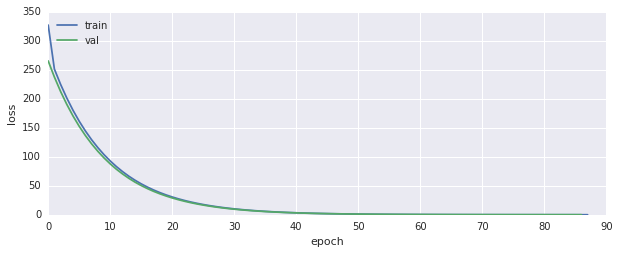

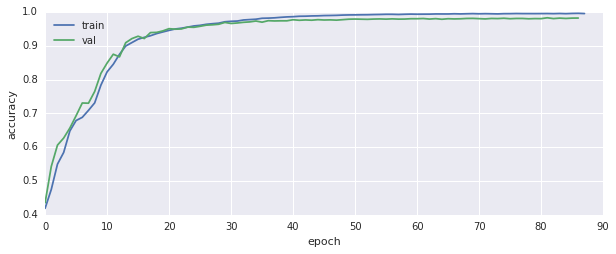

CPU times: user 2min 47s, sys: 32.3 s, total: 3min 19s
Wall time: 2min 8s


In [0]:
%%time 

"""
tf.reset_default_graph()
mdl = DNNClassifier(hidden_sizes=[500, 300], l2_lambda=1e-3)
x, y = mdl.x, mdl.y

with tf.Session() as sess:
  train_losses, train_accs, val_losses, val_accs = train_tf_model(
      mdl,
      session=sess,
      num_epochs=100, 
      optimizer_fn=tf.train.MomentumOptimizer(learning_rate=2e-3, momentum=0.98),
      report_every=1,
      eval_every=1,
      stop_early=True)
  
  # Now evaluate it on the test set:
  accuracy = mdl.accuracy()
  print "Accuracy on test set:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels})
  
  # Plot curves.
  plot_train_val_losses_and_accs(train_losses, val_losses, train_accs, val_accs)  
"""

# Specify the model hyperparameters (NOTE: All the defaults can be omitted):
model_params = {
    'hidden_sizes' : [500, 300], # List of hidden layer dimensions, empty for linear model.
    'l2_lambda' : 1e-3           # Strength of L2 regularization.
}

# Specify the training hyperparameters:
training_params = {'num_epochs' : 100,   # Max epochs/iterations to train for.
            'optimizer_fn' : tf.train.MomentumOptimizer(learning_rate=2e-3, momentum=0.98),
            'report_every' : 1, # Report training results every nr of epochs.
            'eval_every' : 1,   # Evaluate on validation data every nr of epochs.
            'stop_early' : True,  # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True  # Modify as desired.
)

# Additional Resources



* TensorFlow Debugging (useful tips and code patterns): https://github.com/wookayin/tensorflow-talk-debugging
